# SRB Gaussian fit try
Looking for SRB limit division

In [1]:
# data loading
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm, colors
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
from scipy import stats, integrate

%matplotlib inline

## Load Dataset

In [2]:
path = '../datasets/preprocessed/'
rat = pd.read_hdf(path+'velocityDatabase.h5', 'Rat_Behavior').set_index('index')
rat.head(3)

,Frame,Time,X_Pos,Y_Pos,Z_Pos,X_Ori,Y_Ori,Z_Ori,session_id,Filtered,Theta,U,U_var
index,,,,,,,,,,,,,
1,21,0.087500,-0.056324,0.072395,-0.049580,-0.630137,-0.768168,0.025253,0,1,-87.705039,156.977244,NaN
2,22,0.091667,-0.056285,0.072442,-0.049525,-0.630120,-0.767833,0.032642,0,1,-87.034598,160.892886,NaN
3,23,0.095833,-0.056241,0.072488,-0.049468,-0.629928,-0.767622,0.040258,0,1,-86.343297,165.938758,NaN


In [3]:
stim = pd.read_hdf(path+'relationalDatabase.h5', 'Events').set_index('index')
stim.drop(labels=['MotiveExpTimeSecs'], axis=1, inplace=True)

stim.head()

,Frame,Time,visible,speed,session_id
index,,,,,
0,0,0.000000,0,0.0,0
1,0,0.000000,0,0.0,0
2,1,0.004167,0,0.0,0
3,2,0.008333,0,0.0,0
4,3,0.012500,0,0.0,0


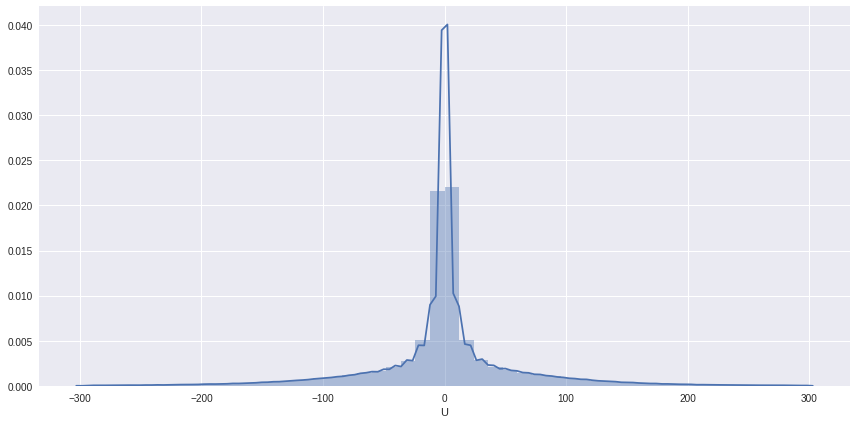

In [4]:
g = sns.FacetGrid(data=rat, size=6, aspect=2)
g.map(sns.distplot, 'U')

## Visualize Relationship between Data and Stimulus

In [5]:
rat_s = pd.merge(rat, stim, on=['Frame', 'Time', 'session_id'])
rat_s.head()

,Frame,Time,X_Pos,Y_Pos,Z_Pos,X_Ori,Y_Ori,Z_Ori,session_id,Filtered,Theta,U,U_var,visible,speed
0,21,0.087500,-0.056324,0.072395,-0.049580,-0.630137,-0.768168,0.025253,0,1,-87.705039,156.977244,NaN,0,0.0
1,22,0.091667,-0.056285,0.072442,-0.049525,-0.630120,-0.767833,0.032642,0,1,-87.034598,160.892886,NaN,0,0.0
2,23,0.095833,-0.056241,0.072488,-0.049468,-0.629928,-0.767622,0.040258,0,1,-86.343297,165.938758,NaN,0,0.0
3,24,0.100000,-0.056195,0.072532,-0.049408,-0.629630,-0.767440,0.048207,0,1,-85.621766,173.153665,NaN,0,0.0
4,25,0.104167,-0.056142,0.072577,-0.049344,-0.629153,-0.767353,0.056476,0,1,-84.870594,180.266748,NaN,0,0.0


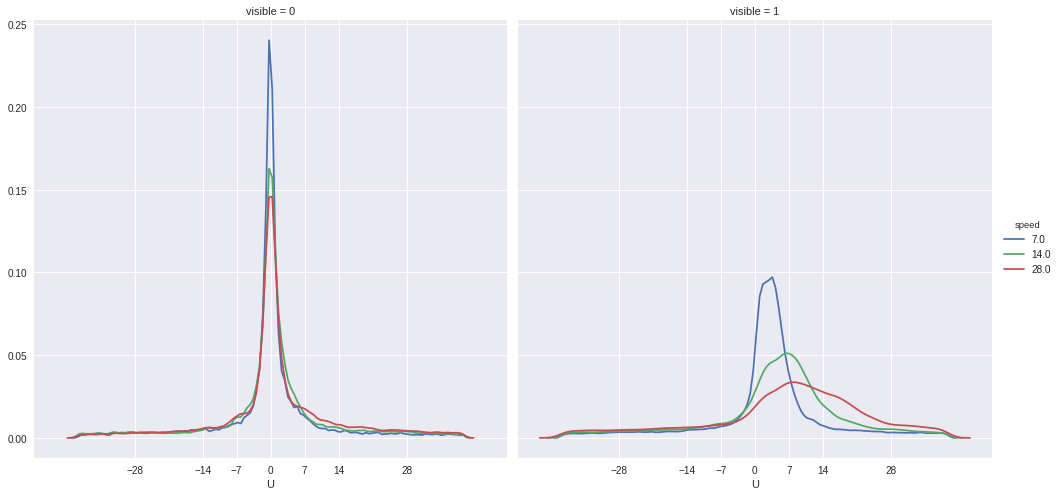

In [6]:
# mask = (0.5 < rat_sv.U) & (rat_sv.U < 40) & (rat_sv.speed >= 0)
mask = (np.abs(rat_s.U) >= 0) & (np.abs(rat_s.U) < 40) & (rat_s.speed > 0)

g = sns.FacetGrid(data=rat_s[mask], hue='speed', col='visible', size=7)
g.map(sns.kdeplot, 'U').add_legend()
g.set(xticks=[-28, -14, -7, 0, 7, 14, 28])#, yscale='log')
# g.map(plt.axvline, x=28, alpha=1, linewidth=1, color='red');

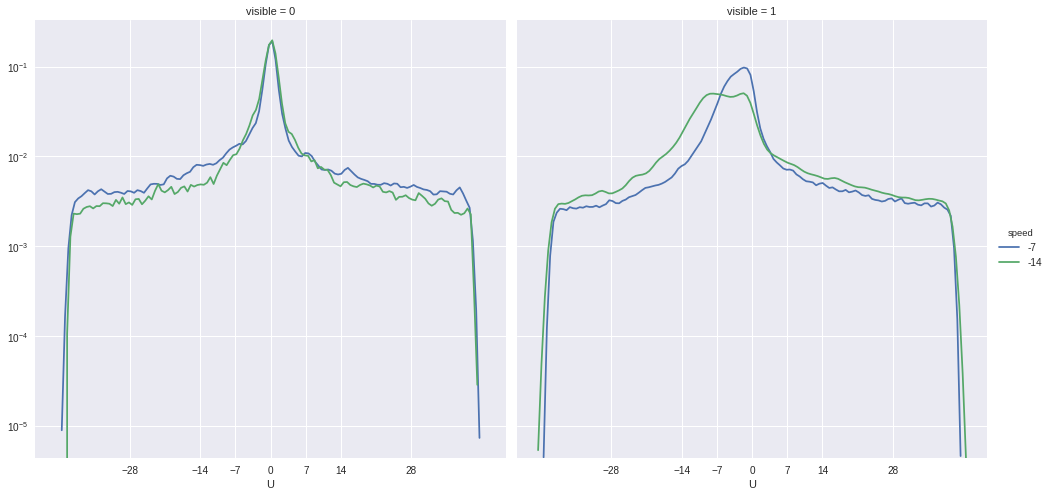

In [7]:
# mask = (0.5 < rat_sv.U) & (rat_sv.U < 40) & (rat_sv.speed >= 0)
mask = (np.abs(rat_s.U) >= 0) & (np.abs(rat_s.U) < 40) & (rat_s.speed < 0) 

g = sns.FacetGrid(data=rat_s[mask], hue='speed', col='visible', hue_order=[-7, -14], size=7)
g.map(sns.kdeplot, 'U').add_legend()
g.set(xticks=[-28, -14, -7, 0, 7, 14, 28], yscale='log')
# g.map(plt.axvline, x=28, alpha=1, linewidth=1, color='red');

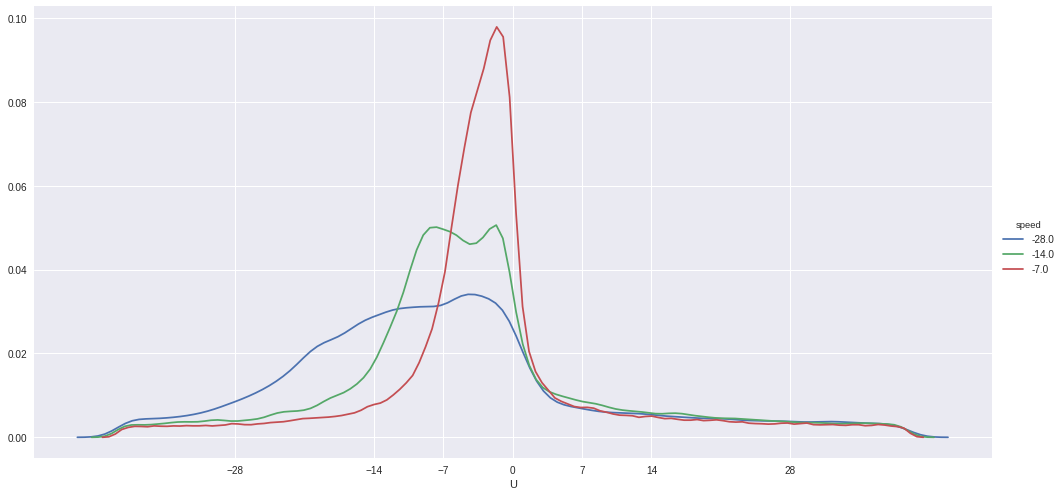

In [8]:
mask2 = (rat_s.visible == True) & (np.abs(rat_s.U) < 40) & (rat_s.speed < 0) & (np.abs(rat_s.U) >= 0) 
g = sns.FacetGrid(data=rat_s[mask2], hue='speed', size=7, aspect=2 )
g.map(sns.kdeplot, 'U').add_legend()
g.set(xticks=[-28, -14, -7, 0, 7, 14, 28])#, yscale='log')

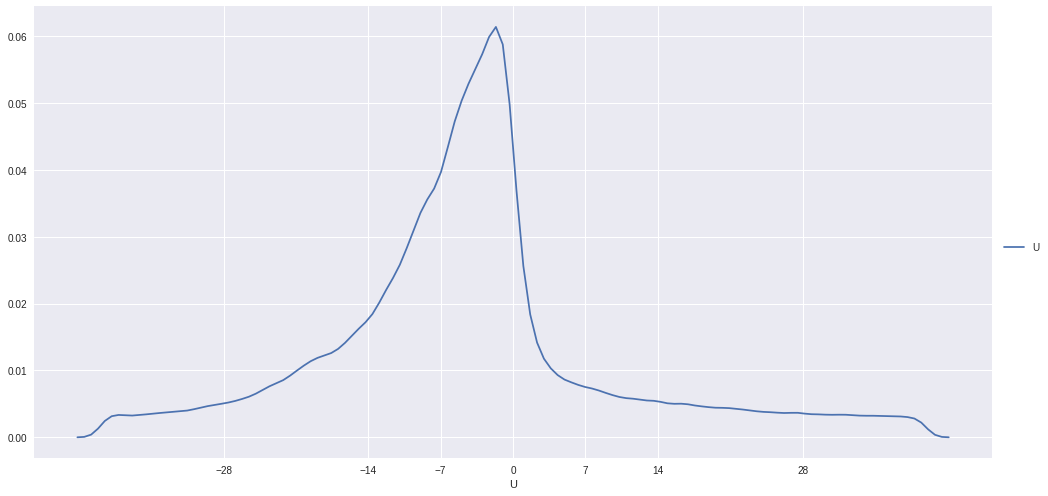

In [9]:
g = sns.FacetGrid(data=rat_s[mask2], size=7, aspect=2 )
g.map(sns.kdeplot, 'U').add_legend()
g.set(xticks=[-28, -14, -7, 0, 7, 14, 28])#, yscale='log')

## Fit in gaussians 

In [10]:
import sklearn.mixture
from scipy.stats import norm

In [11]:
# mask3 = (rat_s.visible == True) & (np.abs(rat_s.U) < 40) & (rat_s.speed < 0) & (np.abs(rat_s.U) >= 0) & (rat_s.session_id==1)
# #Center the x data in zero and normalized the y data to the area of the curve
# n_wave = rat_s[mask3].U
# n_flux = n_wave / sum(n_wave) 

# #Generate a distribution of points matcthing the curve
# line_distribution   = np.random.choice(a = n_wave, size = 100000, p = n_flux)
# number_points       = len(line_distribution)

# #Run the fit
# gmm = GaussianMixture(n_components = 4)
# gmm.fit(np.reshape(line_distribution, (number_points, 1)))
# gauss_mixt = np.array([p * norm.pdf(n_wave, mu, sd) for mu, sd, p in zip(gmm.means_.flatten(), np.sqrt(gmm.covariances_.flatten()), gmm.weights_)])
# gauss_mixt_t = np.sum(gauss_mixt, axis = 0)  

In [12]:
# mask3 = (rat_s.visible == True) & (np.abs(rat_s.U) < 40) & (rat_s.speed < 0) & (np.abs(rat_s.U) >= 0) & (rat_s.session_id==1)
# #Center the x data in zero and normalized the y data to the area of the curve
# n_wave = rat_s[mask3].U
# line_distribution   = np.random.choice(a = n_wave, size = 100000)

# #Run the fit
# gmm = GaussianMixture(n_components = 1)
# n = line_distribution.reshape()
# gmm.fit(n)


## Using sklearn

In [13]:
data1 = np.random.normal(size=1000000)
data2 = np.random.normal(size=100000) * .5 + 2.5

data = np.concatenate((data1, data2))

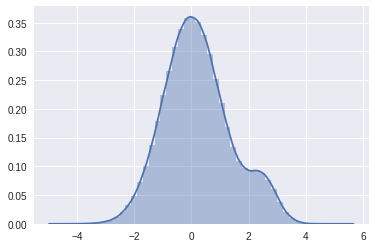

In [14]:
sns.distplot(data)
plt.show()

In [15]:
# fit models with 1-10 components
N = np.arange(1, 11)
models = [None for i in range(len(N))]

data = data.reshape(-1, 1)

for i in range(len(N)):
    models[i] = sklearn.mixture.GaussianMixture(N[i]).fit(data)

# compute the AIC and the BIC
AIC = [m.aic(data) for m in models]
BIC = [m.bic(data) for m in models]

In [16]:
fitted = models[np.argmin(BIC)]

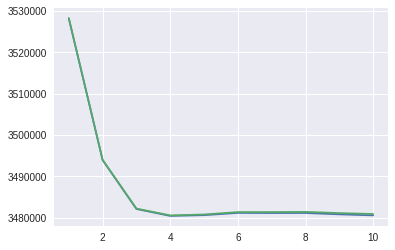

In [17]:
plt.plot(N, AIC)
plt.plot(N, BIC)

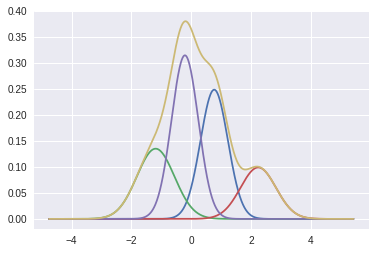

In [18]:
data_range = np.arange(data.min(),data.max(),0.01)
mixture = np.arange(data.min(),data.max(),0.01) * 0

for ind in range(fitted.n_components):

    weight = fitted.weights_[ind]
    mean = fitted.means_[ind, 0]
    var = np.sqrt(fitted.covariances_[ind, 0, 0])  # scipy pdf function accepts std and not variance
    
    plt.plot(np.arange(data.min(),data.max(),0.01), weight * norm.pdf(data_range, mean, var))
    
    mixture += weight * norm.pdf(data_range, mean, var)
    
plt.plot(np.arange(data.min(),data.max(),0.01), mixture)
plt.show()

## Trying it on rat velocity data

### All event evelocities

In [49]:
mask3 = (rat_s.visible == True) & (np.abs(rat_s.U) < 40) & (rat_s.speed != 0) & (np.abs(rat_s.U) >= 0) 
data = rat_s[mask3].reset_index().U
data.head()

0    -8.612539
1    -6.554320
2    -2.064002
3    27.009673
4    27.457899
Name: U, dtype: float64

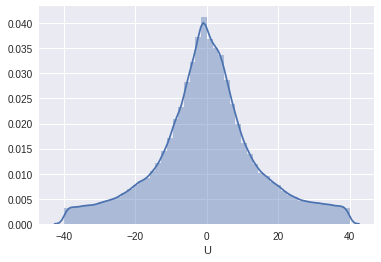

In [50]:
sns.distplot(data)
plt.show()

In [51]:
# fit models with 1-10 components
N = np.arange(1, 7)
models = [None for i in range(len(N))]

data = data.reshape(-1, 1)

for i in range(len(N)):
    models[i] = sklearn.mixture.GaussianMixture(N[i]).fit(data)

# compute the AIC and the BIC
AIC = [m.aic(data) for m in models]
BIC = [m.bic(data) for m in models]

fitted = models[np.argmin(BIC)]


/home/ateska/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  """


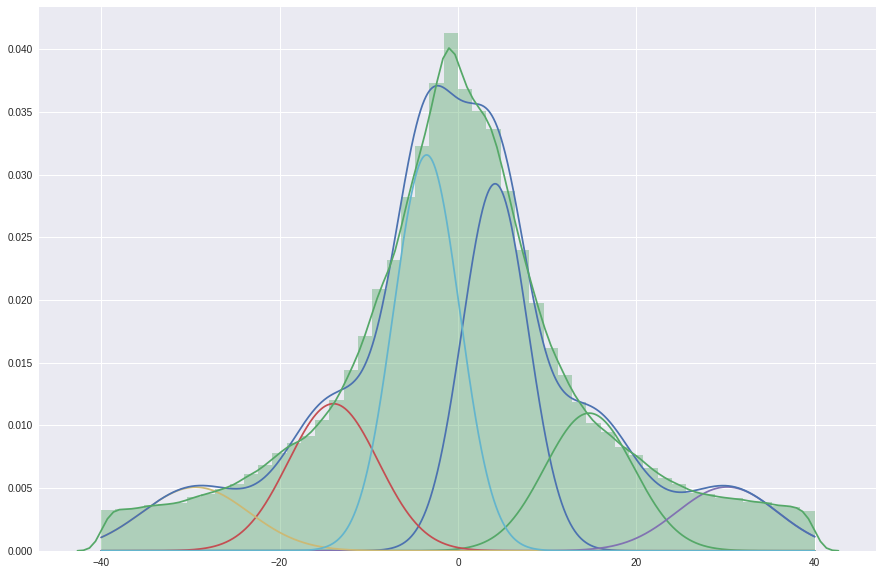

In [52]:
data_range = np.arange(data.min(),data.max(),0.01)
mixture = np.arange(data.min(),data.max(),0.01) * 0


plt.figure(figsize=(15, 10))

for ind in range(fitted.n_components):

    weight = fitted.weights_[ind]
    mean = fitted.means_[ind, 0]
    var = np.sqrt(fitted.covariances_[ind, 0, 0])  # scipy pdf function accepts std and not variance
    
    plt.plot(np.arange(data.min(),data.max(),0.01), weight * norm.pdf(data_range, mean, var))
    
    mixture += weight * norm.pdf(data_range, mean, var)
    

plt.plot(np.arange(data.min(),data.max(),0.01), mixture);
plt.legend
sns.distplot(data)

### Positive event velocities

In [53]:
maskplus = (rat_s.visible == True) & (np.abs(rat_s.U) < 40) & (rat_s.speed >= 0) & (np.abs(rat_s.U) >= 0) 
data = rat_s[maskplus].reset_index().U
data.head()

0   -6.527740
1   -7.613697
2   -8.612539
3   -6.554320
4   -2.064002
Name: U, dtype: float64

In [54]:
# fit models with 1-10 components
N = np.arange(1, 5)
models = [None for i in range(len(N))]

data = data.reshape(-1, 1)

for i in range(len(N)):
    models[i] = sklearn.mixture.GaussianMixture(N[i]).fit(data)

# compute the AIC and the BIC
AIC = [m.aic(data) for m in models]
BIC = [m.bic(data) for m in models]

fitted = models[np.argmin(BIC)]


/home/ateska/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  """


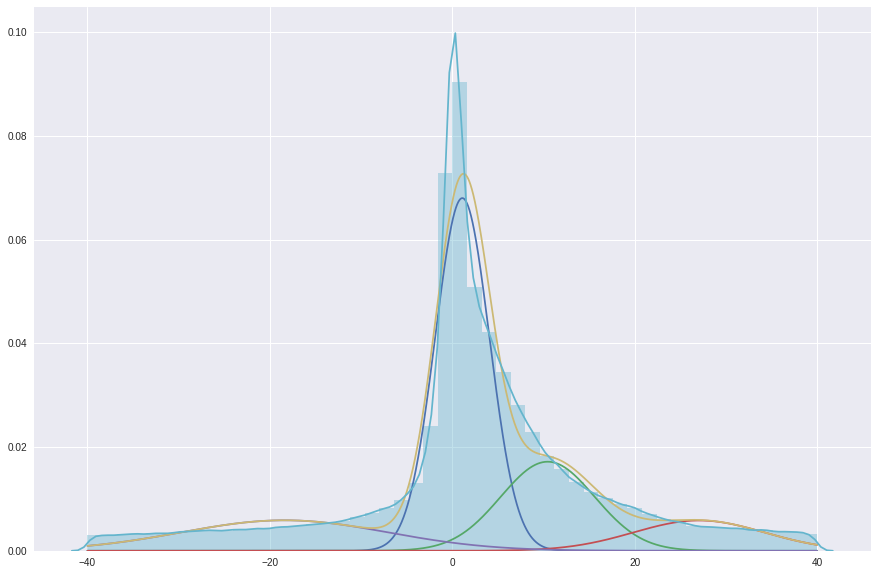

In [55]:
data_range = np.arange(data.min(),data.max(),0.01)
mixture = np.arange(data.min(),data.max(),0.01) * 0


plt.figure(figsize=(15, 10))

for ind in range(fitted.n_components):

    weight = fitted.weights_[ind]
    mean = fitted.means_[ind, 0]
    var = np.sqrt(fitted.covariances_[ind, 0, 0])  # scipy pdf function accepts std and not variance
    
    plt.plot(np.arange(data.min(),data.max(),0.01), weight * norm.pdf(data_range, mean, var))
    
    mixture += weight * norm.pdf(data_range, mean, var)
    

plt.plot(np.arange(data.min(),data.max(),0.01), mixture);
plt.legend
sns.distplot(data)